## In this notebook, we will train a convolutional neural network to segment our satellite images.  We will first use our raw images, and then compare with extra features from previous engineering, such as as dsm with tophat filtering and nvdi.  Once as benchmark is set, we will look into hyperparameter optimization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from preprocessing.preprocessor import Preprocess     #  From usatellite
from models.unet2d.unet2d_model import Unet2d         #  From usatellite
from plot_utils.plotting_utils import SatPlotter      #  From usatellite
from loss.loss_metrics import Loss

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

#TEMP
from tensorflow.compat.v1.nn import sparse_softmax_cross_entropy_with_logits
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf

## First we will load our data.  

In [2]:
imgs_array = np.load('/Users/cody/Python/usattelite_data/img_array.npy')

In [3]:
dsm_array = np.load('/Users/cody/Python/usattelite_data/dsm_array.npy')

In [4]:
nvdi_array = np.load('/Users/cody/Python/usattelite_data/veggies_array.npy')

In [5]:
label_array = np.load('/Users/cody/Python/usattelite_data/label_array.npy')

Let's just start with our images as input to the network to provide a benchmark...  Later we will create more complex data structures, which contain more than just rgb.  These data will add the dsm and/or nvdi images as extra channels.

Let's scale our data, since that is typically helpful for machine learning.

In [6]:
preproc = Preprocess()

In [7]:
imgs_array_scaled = preproc.unit_normalize_dims(imgs_array)

I'm actually going to just use sklearn's train test split to split up the data into traing and test data - there's really no reason to write our own code for this.  We will also shuffle the data and set a random state so it's reproducible.

In [8]:
x_train, x_val, y_train, y_val = train_test_split(imgs_array, label_array, test_size=0.30, shuffle=True, random_state=42)

In [9]:
unet2dmodel = Unet2d(input_img=imgs_array)

In [10]:
unet2dmodel_obj = unet2dmodel.get_unet()

In [11]:
unet2dmodel_obj.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["categorical_accuracy", Loss.f1])

results = unet2dmodel_obj.fit(x_train, y_train, batch_size=6, epochs=100, callbacks=unet2dmodel.callback_list(),
                   validation_data=(x_val, y_val))

In [12]:
loaded_result = unet2dmodel_obj.load_weights('model-test-5.h5')

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(loaded_result.history["f1"], label="f1")
plt.plot(loaded_result.history["val_f1"], label="val_f1")
#plt.plot( np.argmin(results.history["val_f1"]), np.min(results.history["val_f1"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### It looks like the model was able to understand the images and context.

In [13]:
test_imgs = unet2dmodel_obj.predict(x_val)

In [14]:
test_classes = np.argmax(test_imgs, -1)

In [15]:
unet2dmodel_obj.evaluate(x_val, y_val, verbose=1)

1/1 [==============================] - 0s 1ms/step - loss: 0.9195 - categorical_accuracy: 0.7940 - f1: 0.7259


[0.9194549322128296, 0.7940475344657898, 0.7258614301681519]

In [16]:
satplot = SatPlotter()

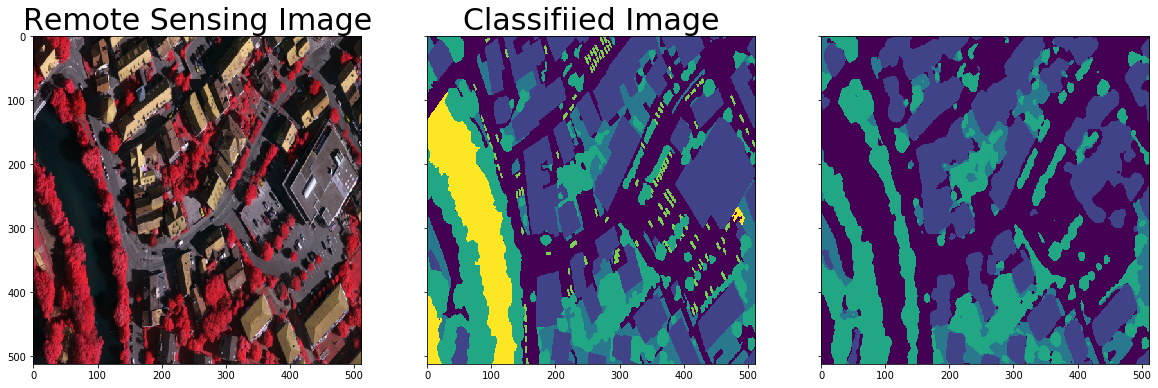

In [17]:
satplot.plot_image_and_result(x_val, y_val, test_classes)

One issue that we notice here with a vanilla UNet setup and standard categorical crossentropy is that the model is too biased by the large classes.  This is a very common class imbalance problem.  There are a number of ways to address this issue...  I tend to like modifying the objective function to obtain the behavior I want.  Modifying the loss per batch based on the class occurrence is what I will try first. 

In [18]:
y_val.shape

(10, 512, 512, 6)

In [19]:
test = K.sum(y_val, axis=0)
#test = K.sum(y_val, axis=-1)

In [20]:
test.shape

TensorShape([512, 512, 6])

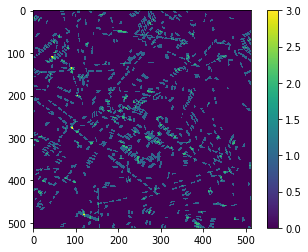

In [21]:
plt.imshow(test[:,:,4])
plt.colorbar();

In [22]:
test2 = K.sum(test,axis=(0,1))

In [23]:
test2

<tf.Tensor: shape=(6,), dtype=uint8, numpy=array([219, 246,  32, 117,  95, 233], dtype=uint8)>

In [24]:
test3 = 1/test2

In [25]:
test3

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([0.00456621, 0.00406504, 0.03125   , 0.00854701, 0.01052632,
       0.00429185], dtype=float32)>

In [26]:
test4 = test3/(np.max(test3))

In [27]:
test4

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([0.14611872, 0.1300813 , 1.        , 0.2735043 , 0.33684212,
       0.13733906], dtype=float32)>

In [28]:
test5 = y_val*test4

In [29]:
test5.shape

TensorShape([10, 512, 512, 6])

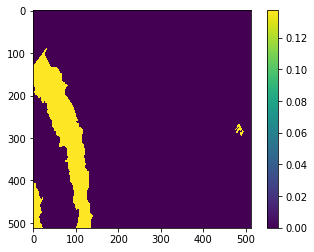

In [30]:
plt.imshow(test5[1,:,:,5])
plt.colorbar();

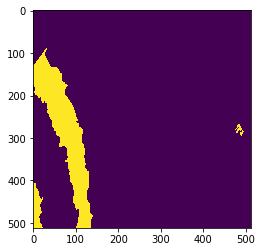

In [31]:
plt.imshow(y_val[1,:,:,5])

In [32]:
def test(y_true):
    
    y_true = K.cast_to_floatx(y_true)
    
    weights = K.sum(y_true, axis=0)
    weights = K.sum(weights,axis=(0,1))
    weights = 1/weights
    weights = weights/(K.max(weights))
    weights = y_true*weights
    
    return weights

In [33]:
testing = test(y_train)

In [34]:
np.shape(testing)

TensorShape([23, 512, 512, 6])

In [35]:
np.shape(y_train)

(23, 512, 512, 6)

In [36]:
categorical_xentropy = CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE, from_logits=True)

In [37]:
def batchwise_weighted_crossentropy(y_true, y_pred):
    
    labels = K.argmax(y_true)
    y_true = K.cast_to_floatx(y_true)
    
    weights = K.sum(y_true, axis=0)
    weights = K.sum(weights,axis=(0,1))
    weights = 1/weights
    weights = weights/(K.max(weights))
    weights = y_true*weights
    print(weights.shape)
    
    loss = categorical_xentropy(y_true, y_pred)
    print(loss.shape)
    #loss = K.cast_to_floatx(loss)
    
    weighted_loss = loss*weights
    #weighted_loss = K.cast_to_floatx(weighted_loss)
    
    return K.sum(weighted_loss)

In [38]:
def get_sample_weight(y_true):
    
    #class_no = []
    #for i in range(len(y_true)):
    #    class_no.append(i)
    
    weights = np.sum(y_true, axis=0)
    weights = np.sum(weights,axis=(0,1))
    weights = 1/weights
    weights = weights/(np.max(weights))
    
    weight_dict = dict(enumerate(weights))
    
    return list(weights)

In [39]:
weights = get_sample_weight(y_train)

In [40]:
weights

[0.020330215834357863,
 0.021371365050506734,
 0.02655898713039931,
 0.022601739012525632,
 0.5057420695723409,
 1.0]

In [44]:
# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0 
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [564]:
unet2dmodel_obj.compile(optimizer=Adam(), loss=batchwise_weighted_crossentropy, metrics=["categorical_accuracy", Loss.f1])

In [45]:
unet2dmodel_obj.compile(optimizer=Adam(), loss=focal_loss, metrics=["categorical_accuracy", Loss.f1])

In [ ]:
results = unet2dmodel_obj.fit(x_train, y_train, batch_size=6, epochs=100, callbacks=unet2dmodel.callback_list(),
                   validation_data=(x_val, y_val))

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 242620.9531 - categorical_accuracy: 0.7891 - f1: 0.7739 
Epoch 00001: val_loss did not improve from inf
4/4 [==============================] - 149s 37s/step - loss: 242620.9531 - categorical_accuracy: 0.7891 - f1: 0.7739 - val_loss: inf - val_categorical_accuracy: 0.6307 - val_f1: 0.5883
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 241604.8750 - categorical_accuracy: 0.7919 - f1: 0.7760 
Epoch 00002: val_loss improved from inf to 1057885.50000, saving model to model-test-5.h5
4/4 [==============================] - 136s 34s/step - loss: 241604.8750 - categorical_accuracy: 0.7919 - f1: 0.7760 - val_loss: 1057885.5000 - val_categorical_accuracy: 0.6456 - val_f1: 0.6039
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 243235.2656 - categorical_accuracy: 0.7918 - f1: 0.7782 
Epoch 00003: val_loss improved from 1057885.50000 to 952890.18750, saving model to model-test-5.h5
4/4 [========

In [48]:
test_imgs = unet2dmodel_obj.predict(x_val)

In [49]:
test_classes = np.argmax(test_imgs, -1)

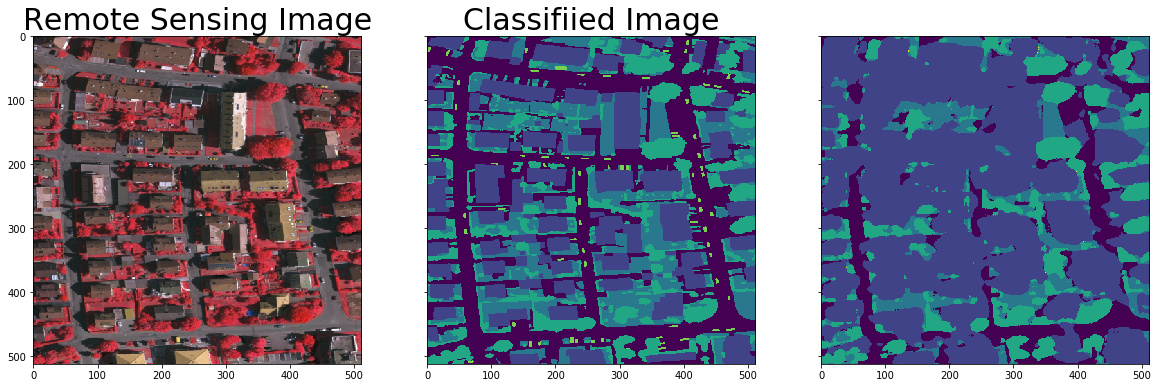

In [54]:
satplot.plot_image_and_result(x_val, y_val, test_classes)